In [19]:
%load_ext autoreload
%autoreload 2
%pylab inline

import itertools
import pickle

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange, tqdm_notebook as tqdmn

from BEKML import BEMKL, plot_distplot
from utils import poly_kernel, gauss_kernel, scoring, plot_kernel_importances, plot_e_a_mu, plot_compare_metrics

sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
tqdm.monitor_interval = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
display(X.shape, y.shape, y.mean())

(683, 9)

(683,)

-0.3001464128843338

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(130, 130)

In [5]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [8]:
max_iter = 200
model = BEMKL(kernels=kernels, hyp_lambda_alpha=1, hyp_lambda_beta=1,
               hyp_gamma_alpha=1, hyp_gamma_beta=1,
               hyp_omega_alpha=1, hyp_omega_beta=1,
               e_null_thrsh=1e-3, filter_kernels=True, filter_sv=True, verbose=10,
               max_iter=max_iter, hyperopt_enabled=False)
normalizer = Normalizer()
pipeline = make_pipeline(normalizer, model)
pipeline.fit(X_train, y_train)
model = pipeline.named_steps['bemkl']

Iter: 10. Bound: -1393.7408
Iter: 20. Bound: -1342.0144
Iter: 30. Bound: -1315.0715
Iter: 40. Bound: -1283.7020
Iter: 50. Bound: -1273.2472
Iter: 60. Bound: -1265.6452
Iter: 70. Bound: -1262.2886
Iter: 80. Bound: -1258.4016
Iter: 90. Bound: -1251.3758
Iter: 100. Bound: -1247.4524
Iter: 110. Bound: -1244.2611
Iter: 120. Bound: -1241.1299
Iter: 130. Bound: -1237.8235
Iter: 140. Bound: -1234.1453
Iter: 150. Bound: -1229.7275
Iter: 160. Bound: -1222.8781
Iter: 170. Bound: -1213.5818
Iter: 180. Bound: -1210.1987
Iter: 190. Bound: -1206.8417
Iter: 200. Bound: -1202.9096
Iterations total time: 16.2450


In [9]:
model_kernels = model.kernels
model_kernels_orig = model.kernels_orig

with open('breast_model.pickle', 'wb') as fp:
    model.set_params(kernels=None)
    model.kernels_orig = None
    pickle.dump(pipeline, fp)

model.set_params(kernels=model_kernels)
model.kernels_orig = model_kernels_orig

In [21]:
with open('breast_model.pickle', 'rb') as fp:
    pipeline = pickle.load(fp)

model = pipeline.named_steps['bemkl']    
model.set_params(kernels=kernels)
model.kernels_orig = kernels

In [11]:
y_pred_proba = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)
y_pred_proba.shape, y_pred.shape

((205, 2), (205,))

In [12]:
Km_train = model.Km_train
Km_test = model.Km_test

In [13]:
savemat('Km.mat', {
    'Km_train': Km_train.transpose(1, 2, 0),
    'y_train': y_train,
    'Km_test': Km_test.transpose(2, 1, 0),
    'y_test': y_test,
    'init_vars': model.init_vars
})

In [12]:
predictions_mat = loadmat('prediction.mat')['prediction'][0, 0]
(predictions_mat['G']['mu'][0, 0].shape, predictions_mat['G']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['p'].shape)

((130, 205), (130, 205), (205, 1), (205, 1), (205, 1), (205, 1), (205, 1))

In [13]:
display(log_loss(y_test, predictions_mat['p']),
        log_loss(y_test, y_pred_proba))
display(mean_squared_error(y_pred_proba[:, 1].flatten(), predictions_mat['p'].flatten()))

0.4626318193480981

0.46262976301294484

1.0924441585403234e-11

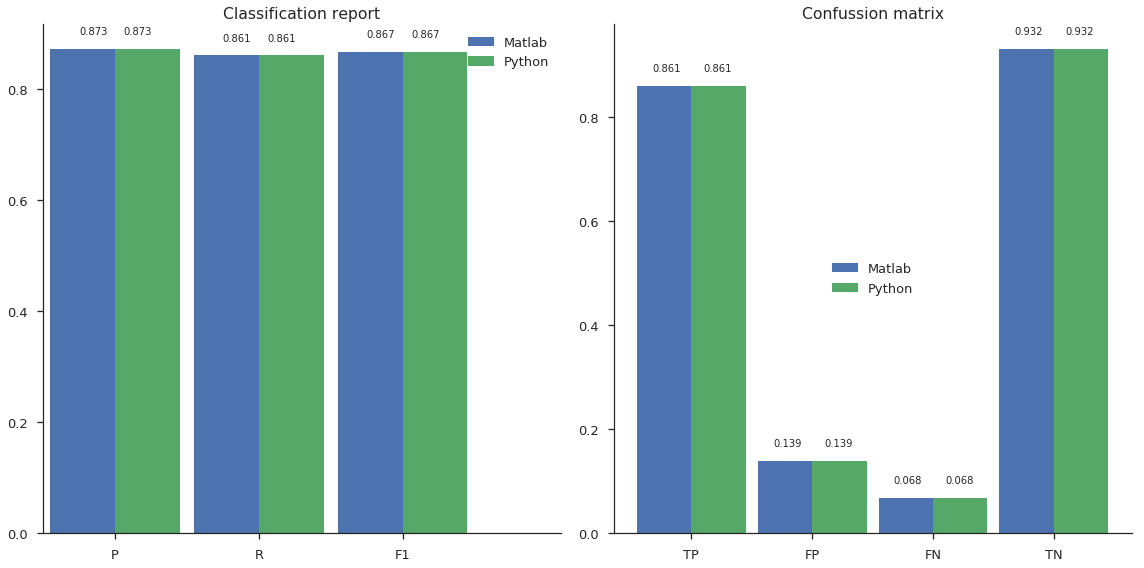

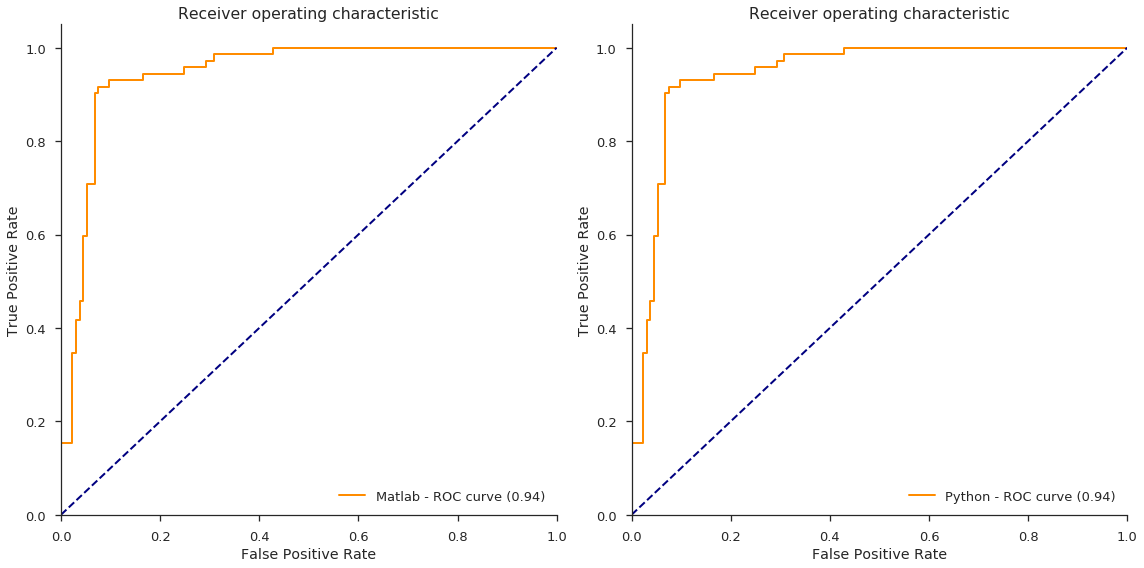

In [14]:
y_pred_proba_mat = predictions_mat['p']
y_pred_mat = np.ones_like(y_pred_proba_mat)
y_pred_mat[y_pred_proba_mat < 0.5] = -1

plot_compare_metrics(y_test, y_pred_mat, y_pred, y_pred_proba_mat, y_pred_proba[:, 1], 'Matlab', 'Python')

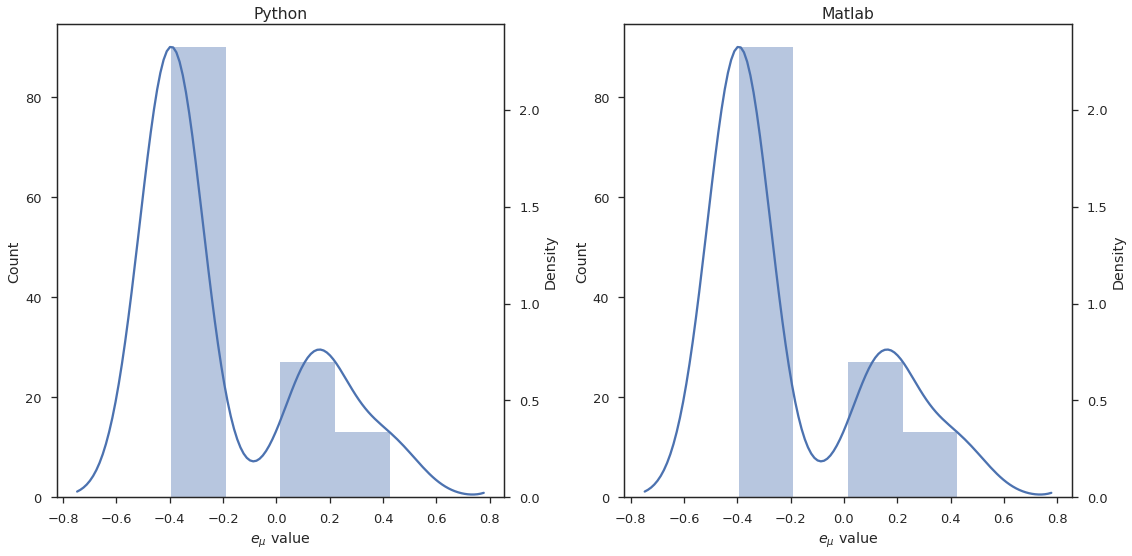

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
model.plot_e(ax=ax1)
plot_distplot(predictions_mat['be']['mu'][0, 0][1:, 0], r'$e_\mu$', ax=ax2)
ax1.set_title('Python')
ax2.set_title('Matlab')
plt.tight_layout()

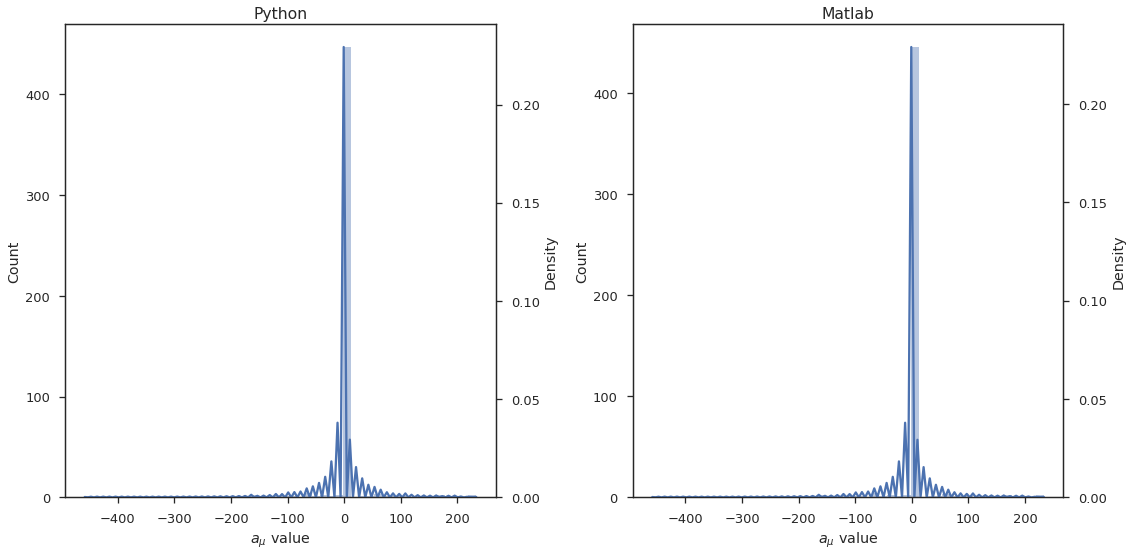

In [23]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
model.plot_a(ax=ax1)
plot_distplot(predictions_mat['a']['mu'][0, 0][1:, 0], r'$a_\mu$', ax=ax2)
ax1.set_title('Python')
ax2.set_title('Matlab')
plt.tight_layout()

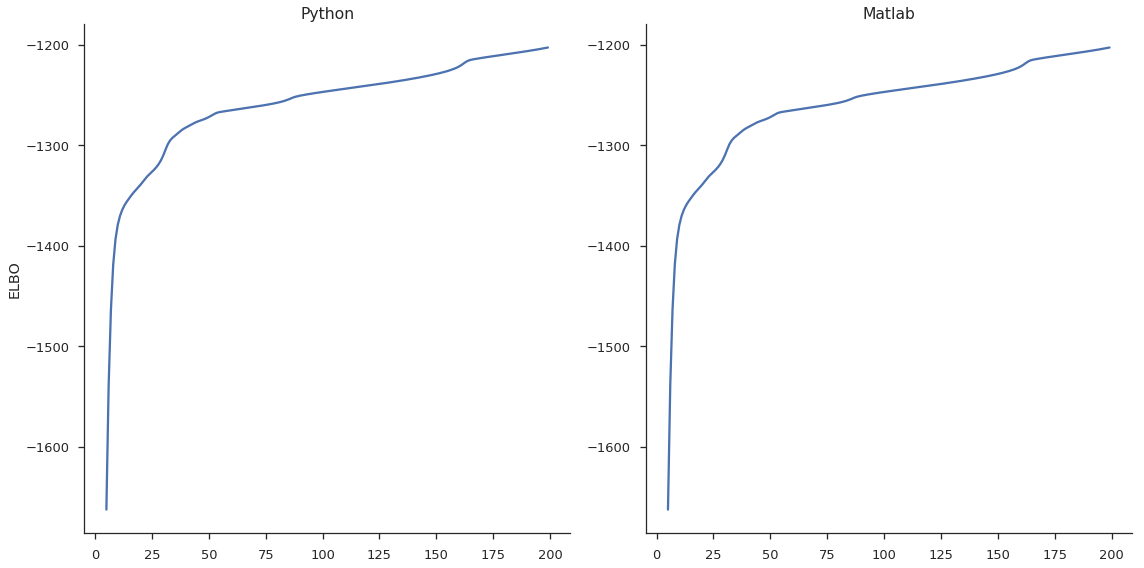

In [17]:
_, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes.flatten()

from_iter = 5
x = np.arange(from_iter, len(model.bounds))
ax1.plot(x, [b[0] for b in model.bounds[from_iter:]])
ax2.plot(x, predictions_mat['bounds'][from_iter:, 0])

ax1.set_title('Python')
ax2.set_title('Matlab')
ax1.set_ylabel('ELBO')

sns.despine()
plt.tight_layout()

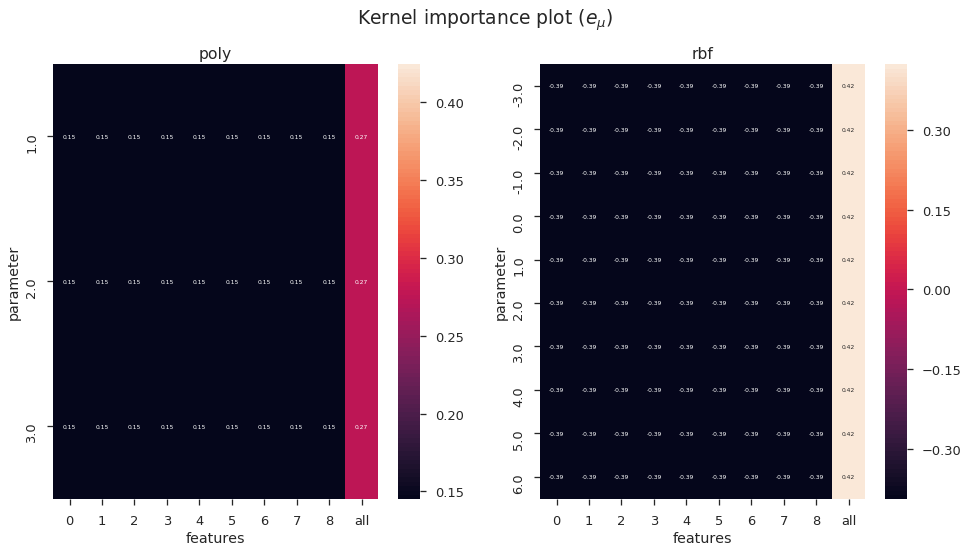

In [24]:
from utils import plot_kernel_importances

plot_kernel_importances(model.b_e_mu_orig[0, 1:], kernel_attrs)

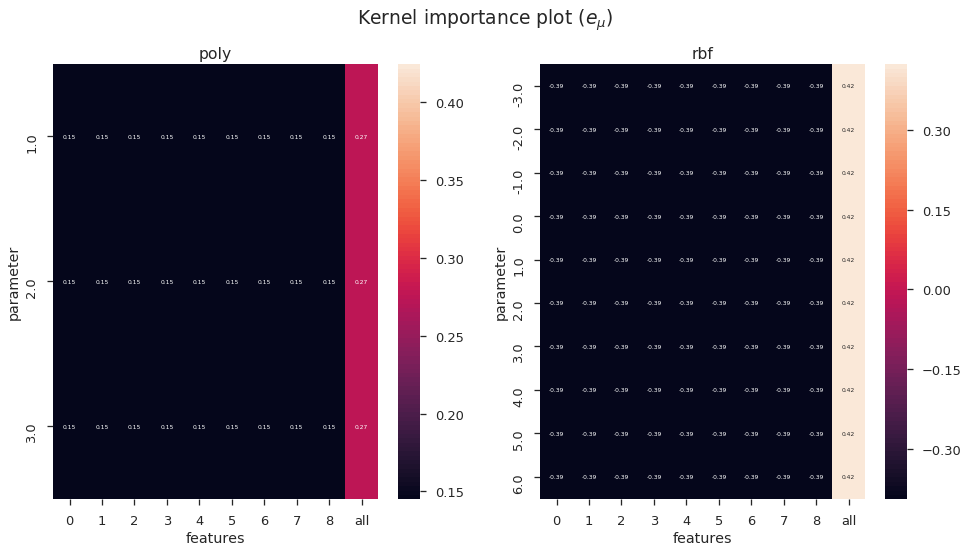

In [36]:
from utils import plot_kernel_importances

plot_kernel_importances(predictions_mat['be']['mu'][0, 0][1:, 0], kernel_attrs)

In [24]:
max_iter = 200
normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train)

n_iterations = 20
elapsed_times = np.zeros(n_iterations)
for i in tqdmn(np.arange(n_iterations)):
    model = BEMKL(kernels=kernels, hyp_lambda_alpha=1, hyp_lambda_beta=1,
                   hyp_gamma_alpha=1, hyp_gamma_beta=1,
                   hyp_omega_alpha=1, hyp_omega_beta=1,
                   e_null_thrsh=1e-3, filter_kernels=True, filter_sv=True, verbose=False,
                   max_iter=max_iter, hyperopt_enabled=False, calculate_bounds=False)
    model.fit(X_train, y_train)
    elapsed_times[i] = model.total_time

elapsed_times.mean(), elapsed_times.std()

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

(11.093655908107758, 1.8431796562054499)

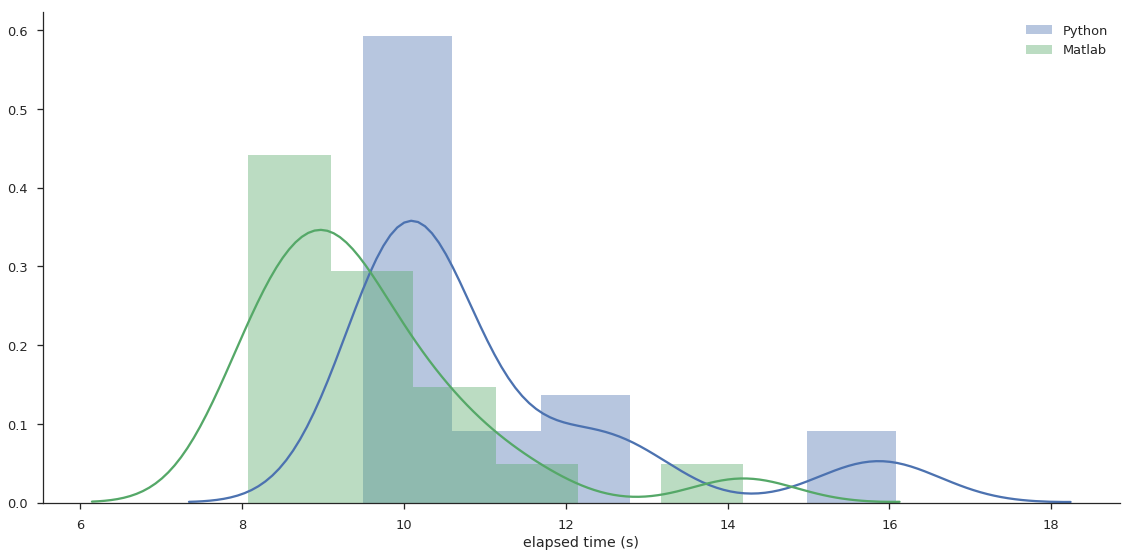

In [27]:
elapsed_times_mat = np.array([
    14.1961, 11.5141, 10.8128,  9.0120,  9.1939,
     8.9608,  9.4317,  9.3397, 10.3299,  9.4855,
     9.1675, 10.2079, 10.0634,  8.9732,  8.6711,
     8.2223,  8.0837,  8.2950,  8.0768,  8.4221])

plt.figure(figsize=(16, 8))
sns.distplot(elapsed_times, label='Python')
sns.distplot(elapsed_times_mat, label='Matlab')
plt.xlabel('elapsed time (s)')
plt.legend()
sns.despine()
plt.tight_layout()